In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize

# Environment Setup

In [3]:
class StochasticPricingEnvironment:
    """
    Stochastic environment for dynamic pricing with customer valuation uncertainty.
    
    This environment simulates a single-product pricing scenario where:
    - Customers have valuations drawn from a known distribution
    - The probability of purchase depends on whether customer valuation >= price
    - Each round represents one customer interaction
    """
    def __init__(self, valuation_distribution):
        """
        Initialize the pricing environment.
        
        Args:
            valuation_distribution: A scipy.stats distribution representing customer valuations
        """
        self.valuation_dist = valuation_distribution
        
    def demand_probability(self, price):
        """
        Calculate the theoretical probability that a customer purchases at given price.
        
        This is the complement of the CDF: P(valuation >= price) = 1 - F(price)
        where F is the cumulative distribution function of customer valuations.
        
        Args:
            price: The price to evaluate
            
        Returns:
            Probability that a randomly drawn customer will purchase at this price
        """
        return 1 - self.valuation_dist.cdf(price)

    def simulate_round(self, price):
        """
        Simulate one customer interaction at the given price.
        
        Args:
            price: The price offered to the customer
            
        Returns:
            tuple: (sale_made, revenue) where:
                - sale_made: 1 if customer purchased, 0 otherwise
                - revenue: price if sale was made, 0 otherwise
        """
        # Draw a random customer valuation from the distribution
        valuation = self.valuation_dist.rvs()
        
        # Customer purchases if their valuation >= price
        sale_made = 1 if valuation >= price else 0
        
        # Revenue is price if sale was made, 0 otherwise
        revenue = sale_made * price
        
        return sale_made, revenue

# Agent Setup

In [4]:
class UCBLikeAgent:
    """
    UCB1-based agent for dynamic pricing with inventory constraints.
    
    This agent implements a variant of the UCB1 algorithm adapted for:
    1. Dynamic pricing (instead of traditional MAB rewards)
    2. Inventory constraints (limited number of products to sell)
    3. Dual optimization: maximize revenue while respecting inventory constraint
    
    The algorithm maintains upper confidence bounds on revenue (f_UCB) and 
    lower confidence bounds on demand probability (c_LCB), then solves a 
    linear program to find the optimal price distribution.
    """
    
    def __init__(self, P, T, prices, confidence_bound=2, rho_penalty=1.0,use_pen_rho=True):
        """
        Initialize the UCB agent for constrained dynamic pricing.
        
        Args:
            P: Total inventory (number of products available)
            T: Time horizon (number of rounds)
            prices: List of available prices to choose from
            confidence_bound: Confidence parameter for UCB/LCB bounds
            rho_penalty: Penalty factor for inventory constraint (>1 = more conservative)
        """
        k = len(prices)

        # Environment parameters
        self.use_pen_rho=use_pen_rho
        self.prices = prices  # Available price options
        self.K = k           # Number of price arms
        self.T = T           # Total number of rounds
        self.confidence_bound = confidence_bound  # UCB confidence parameter
        
        # Current state
        self.current_price_idx = None  # Index of currently selected price
        self.t = 0                     # Current round number
        
        # Statistics for each price arm
        self.avg_revenue = np.zeros(k)  # Average revenue per price
        self.avg_demand = np.zeros(k)   # Average demand probability per price
        self.N_pulls = np.zeros(k)      # Number of times each price was selected
        
        # Inventory management
        self.inventory = P               # Initial inventory
        self.remaining_inventory = P     # Current remaining inventory
        self.rho = P / T                # Target selling rate
        self.rho_penalty = rho_penalty  # Penalty factor for inventory constraint
        
        # History tracking
        self.history = {
            'prices': [],     # Selected prices over time
            'rewards': [],    # Observed revenues over time
            'purchases': [],  # Purchase indicators over time
            'inventory': []   # Inventory levels over time
        }
    
    def select_price(self):
        """
        Select the next price using UCB1 with inventory constraints.
        
        Strategy:
        1. If inventory is empty, return NaN (no meaningful price)
        2. First K rounds: explore each price once (initialization)
        3. Subsequent rounds: solve LP with UCB revenue bounds and LCB demand bounds
        
        Returns:
            Selected price, or np.nan if no inventory remaining
        """
        # No inventory left - cannot make meaningful pricing decisions
        if self.remaining_inventory < 1:
            self.current_price_idx = np.argmax(self.prices)  # Arbitrary selection
            return np.nan
            
        # Exploration phase: try each price at least once
        if self.t < self.K:
            self.current_price_idx = self.t
        # Exploitation-Exploration phase: use UCB with inventory constraints
        
        else:            
            # Compute upper confidence bounds on revenue for each price
            confidence_radius = self.confidence_bound * np.sqrt(2 * np.log(self.T) / np.maximum(self.N_pulls, 1))
            f_ucbs = self.avg_revenue + confidence_radius
            
            # Compute lower confidence bounds on demand probability for each price
            # Use a slightly more conservative bound for demand to improve regret
            
            demand_confidence_radius = self.confidence_bound * np.sqrt(2 * np.log(self.t) / np.maximum(self.N_pulls, 1))
            c_lcbs = np.maximum(0, self.avg_demand - demand_confidence_radius)
            
            # Solve linear program to get optimal price distribution
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)
            
            # Sample price according to computed distribution
            self.current_price_idx = np.random.choice(self.K, p=gamma_t)

        return self.prices[self.current_price_idx]

    def compute_opt(self, f_ucbs, c_lcbs): 
        """
        Solve constrained optimization problem to find optimal price distribution.
        
        Formulation:
        maximize: sum_i gamma_i * f_ucb_i (expected revenue)
        subject to: sum_i gamma_i * c_lcb_i <= rho_penalty * current_rho (inventory constraint)
                   sum_i gamma_i = 1 (probability constraint)
                   gamma_i >= 0 (non-negativity)
        
        where current_rho is the required selling rate to use remaining inventory.
        
        Args:
            f_ucbs: Upper confidence bounds on revenue for each price
            c_lcbs: Lower confidence bounds on demand probability for each price
            
        Returns:
            gamma: Probability distribution over prices
        """
        # Handle edge case: if no positive demand expected, choose highest revenue price
        if np.all(c_lcbs <= 1e-10):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1.0
            return gamma
        
        # Convert to minimization problem (negate revenues)
        c = -f_ucbs
        
        # Compute current required selling rate
        remaining_rounds = max(1, self.T - self.t)
        current_rho = max(self.remaining_inventory / remaining_rounds, 0)
        

        # Linear program constraints
        A_ub = [c_lcbs]      # Inventory constraint coefficients
        
        if self.use_pen_rho:
            
            # Apply penalty to make constraint more conservative, but not too tight
            # If inventory is high relative to time remaining, relax the constraint
            inventory_ratio = self.remaining_inventory / self.inventory
            time_ratio = (self.T - self.t) / self.T
            
            if inventory_ratio > 0.5 and time_ratio > 0.5:
                # Early stages with plenty of inventory: relax constraint
                penalty_factor = self.rho_penalty * 1.5
            elif inventory_ratio < 0.1:
                # Low inventory: tighten constraint
                penalty_factor = self.rho_penalty * 0.5
            else:
                penalty_factor = self.rho_penalty
                
            penalized_rho = current_rho * penalty_factor
            
            # If the constraint is too tight (lower than minimum demand), relax it
            min_demand = np.min(c_lcbs[c_lcbs > 0]) if np.any(c_lcbs > 0) else 0
            
            if penalized_rho < min_demand * 0.5:
                penalized_rho = min_demand * 0.8
            
            b_ub = [penalized_rho]       # Inventory constraint bound
        
        
        else:

            b_ub = [current_rho]       # Inventory constraint bound

        A_eq = [np.ones(self.K)]     # Probability constraint coefficients  
        b_eq = [1]                   # Probability constraint bound
        
        
        # Solve linear program
        try:
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                                 bounds=[(0, 1) for _ in range(self.K)], method='highs')
            if res.success:
                gamma = res.x
                # Ensure valid probability distribution
                gamma = np.maximum(gamma, 0)
                gamma = gamma / np.sum(gamma) if np.sum(gamma) > 0 else np.ones(self.K) / self.K
                return gamma
            else:
                # Fallback: uniform distribution
                return np.ones(self.K) / self.K
        except:
            # Fallback: uniform distribution
            return np.ones(self.K) / self.K
    
    def update(self, reward, purchased):
        """
        Update agent's statistics based on observed outcome.
        
        Args:
            reward: Revenue obtained (price if purchased, 0 otherwise)
            purchased: Boolean indicating if purchase was made
        """
        idx = self.current_price_idx
        
        # Update pull count
        self.N_pulls[idx] += 1
        
        # Update average revenue using incremental mean formula
        self.avg_revenue[idx] += (reward - self.avg_revenue[idx]) / self.N_pulls[idx]
        
        # Update average demand probability
        purchased_indicator = 1.0 if purchased else 0.0
        self.avg_demand[idx] += (purchased_indicator - self.avg_demand[idx]) / self.N_pulls[idx]
        
        # Update inventory only if purchase was actually made and inventory available
        if purchased and self.remaining_inventory > 0:
            self.remaining_inventory -= 1
        elif purchased and self.remaining_inventory <= 0:
            # This shouldn't happen with proper price selection, but handle gracefully
            reward = 0
            purchased = False
        
        # Record history
        self.history['prices'].append(self.prices[idx])
        self.history['rewards'].append(reward)
        self.history['purchases'].append(purchased)
        self.history['inventory'].append(self.remaining_inventory)
        
        # Increment time
        self.t += 1

    def get_best_price(self):
        """
        Return the price with highest average revenue observed so far.
        
        Returns:
            tuple: (best_price, best_average_revenue)
        """
        best_idx = np.argmax(self.avg_revenue)
        return self.prices[best_idx], self.avg_revenue[best_idx]

In [5]:
class ThompsonSamplingAgent:
    """
    Thompson Sampling agent for dynamic pricing with inventory constraints.
    
    This agent implements Thompson Sampling adapted for:
    1. Dynamic pricing (instead of traditional MAB rewards)
    2. Inventory constraints (limited number of products to sell)
    3. Dual optimization: maximize revenue while respecting inventory constraint
    
    The algorithm maintains Beta distributions for demand probabilities and 
    Gaussian distributions for revenues, then samples from these posteriors 
    and solves a linear program to find the optimal price distribution.
    """
    
    def __init__(self, P, T, prices, rho_penalty=1.0):
        """
        Initialize the Thompson Sampling agent for constrained dynamic pricing.
        
        Args:
            P: Total inventory (number of products available)
            T: Time horizon (number of rounds)
            prices: List of available prices to choose from
            rho_penalty: Penalty factor for inventory constraint (>1 = more conservative)
        """
        k = len(prices)

        # Environment parameters
        self.prices = prices  # Available price options
        self.K = k           # Number of price arms
        self.T = T           # Total number of rounds
        
        # Current state
        self.current_price_idx = None  # Index of currently selected price
        self.t = 0                     # Current round number
        
        # Beta distribution parameters for demand probabilities (Thompson Sampling)
        self.alpha = np.ones(k)  # Success count + 1 (prior)
        self.beta = np.ones(k)   # Failure count + 1 (prior)
        
        # Gaussian distribution parameters for revenues (Thompson Sampling)
        self.revenue_sum = np.zeros(k)     # Sum of observed revenues
        self.revenue_sum_sq = np.zeros(k)  # Sum of squared revenues
        self.N_pulls = np.zeros(k)         # Number of pulls per arm
        
        # Statistics for tracking
        self.avg_revenue = np.zeros(k)  # Average revenue per price
        self.avg_demand = np.zeros(k)   # Average demand probability per price
        
        # Inventory management
        self.inventory = P               # Initial inventory
        self.remaining_inventory = P     # Current remaining inventory
        self.rho = P / T                # Target selling rate
        self.rho_penalty = rho_penalty  # Penalty factor for inventory constraint
        
        # History tracking
        self.history = {
            'prices': [],     # Selected prices over time
            'rewards': [],    # Observed revenues over time
            'purchases': [],  # Purchase indicators over time
            'inventory': []   # Inventory levels over time
        }
    
    def select_price(self):
        """
        Select the next price using Thompson Sampling with inventory constraints.
        
        Strategy:
        1. If inventory is empty, return NaN (no meaningful price)
        2. Sample from posterior distributions for revenue and demand
        3. Solve LP with sampled values to respect inventory constraints
        
        Returns:
            Selected price, or np.nan if no inventory remaining
        """
        # No inventory left - cannot make meaningful pricing decisions
        if self.remaining_inventory < 1:
            self.current_price_idx = np.argmax(self.prices)  # Arbitrary selection
            return np.nan
            
        # Sample from posterior distributions
        # Sample demand probabilities from Beta distributions
        sampled_demands = np.random.beta(self.alpha, self.beta)
        
        # Sample revenues from Gaussian distributions
        sampled_revenues = np.zeros(self.K)
        for i in range(self.K):
            if self.N_pulls[i] > 0:
                # Posterior parameters for Gaussian
                mean = self.revenue_sum[i] / self.N_pulls[i]
                # Use sample variance with some regularization
                if self.N_pulls[i] > 1:
                    variance = max(1e-6, (self.revenue_sum_sq[i] / self.N_pulls[i] - mean**2) / self.N_pulls[i])
                else:
                    variance = (self.prices[i] / 4)**2  # Prior variance based on price range
                sampled_revenues[i] = np.random.normal(mean, np.sqrt(variance))
            else:
                # Prior: sample around the price itself with some uncertainty
                sampled_revenues[i] = np.random.normal(self.prices[i] * 0.5, self.prices[i] / 4)
        
        # Ensure non-negative revenues
        sampled_revenues = np.maximum(sampled_revenues, 0)
        
        # Solve linear program to get optimal price distribution
        gamma_t = self.compute_opt(sampled_revenues, sampled_demands)
        
        # Sample price according to computed distribution
        self.current_price_idx = np.random.choice(self.K, p=gamma_t)

        return self.prices[self.current_price_idx]

    def compute_opt(self, sampled_revenues, sampled_demands): 
        """
        Solve constrained optimization problem to find optimal price distribution.
        
        Formulation:
        maximize: sum_i gamma_i * sampled_revenue_i (expected revenue)
        subject to: sum_i gamma_i * sampled_demand_i <= rho_penalty * current_rho (inventory constraint)
                   sum_i gamma_i = 1 (probability constraint)
                   gamma_i >= 0 (non-negativity)
        
        where current_rho is the required selling rate to use remaining inventory.
        
        Args:
            sampled_revenues: Sampled revenues from posterior distributions
            sampled_demands: Sampled demand probabilities from posterior distributions
            
        Returns:
            gamma: Probability distribution over prices
        """
        # Handle edge case: if no positive demand expected, choose highest revenue price
        if np.all(sampled_demands <= 1e-10):
            gamma = np.zeros(len(sampled_revenues))
            gamma[np.argmax(sampled_revenues)] = 1.0
            return gamma
        
        # Convert to minimization problem (negate revenues)
        c = -sampled_revenues
        
        # Compute current required selling rate
        remaining_rounds = max(1, self.T - self.t)
        current_rho = max(self.remaining_inventory / remaining_rounds, 0)
        
        # Apply penalty to make constraint more conservative, but not too tight
        # If inventory is high relative to time remaining, relax the constraint
        inventory_ratio = self.remaining_inventory / self.inventory
        time_ratio = (self.T - self.t) / self.T
        
        if inventory_ratio > 0.5 and time_ratio > 0.5:
            # Early stages with plenty of inventory: relax constraint
            penalty_factor = self.rho_penalty * 1.5
        elif inventory_ratio < 0.1:
            # Low inventory: tighten constraint
            penalty_factor = self.rho_penalty * 0.5
        else:
            penalty_factor = self.rho_penalty
            
        penalized_rho = current_rho * penalty_factor
        
        # If the constraint is too tight (lower than minimum demand), relax it
        min_demand = np.min(sampled_demands[sampled_demands > 0]) if np.any(sampled_demands > 0) else 0
        if penalized_rho < min_demand * 0.5:
            penalized_rho = min_demand * 0.8
        
        # Linear program constraints
        A_ub = [sampled_demands]         # Inventory constraint coefficients
        b_ub = [penalized_rho]           # Inventory constraint bound
        A_eq = [np.ones(self.K)]         # Probability constraint coefficients  
        b_eq = [1]                       # Probability constraint bound
        
        # Solve linear program
        try:
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                                 bounds=[(0, 1) for _ in range(self.K)], method='highs')
            if res.success:
                gamma = res.x
                # Ensure valid probability distribution
                gamma = np.maximum(gamma, 0)
                gamma = gamma / np.sum(gamma) if np.sum(gamma) > 0 else np.ones(self.K) / self.K
                return gamma
            else:
                # Fallback: uniform distribution
                return np.ones(self.K) / self.K
        except:
            # Fallback: uniform distribution
            return np.ones(self.K) / self.K
    
    def update(self, reward, purchased):
        """
        Update agent's posterior distributions based on observed outcome.
        
        Args:
            reward: Revenue obtained (price if purchased, 0 otherwise)
            purchased: Boolean indicating if purchase was made
        """
        idx = self.current_price_idx
        
        # Update Beta distribution parameters for demand probability
        if purchased:
            self.alpha[idx] += 1  # Success
        else:
            self.beta[idx] += 1   # Failure
        
        # Update Gaussian distribution parameters for revenue
        self.revenue_sum[idx] += reward
        self.revenue_sum_sq[idx] += reward**2
        self.N_pulls[idx] += 1
        
        # Update running averages for tracking
        self.avg_revenue[idx] += (reward - self.avg_revenue[idx]) / self.N_pulls[idx]
        purchased_indicator = 1.0 if purchased else 0.0
        self.avg_demand[idx] += (purchased_indicator - self.avg_demand[idx]) / self.N_pulls[idx]
        
        # Update inventory only if purchase was actually made and inventory available
        if purchased and self.remaining_inventory > 0:
            self.remaining_inventory -= 1
        elif purchased and self.remaining_inventory <= 0:
            # This shouldn't happen with proper price selection, but handle gracefully
            reward = 0
            purchased = False
        
        # Record history
        self.history['prices'].append(self.prices[idx])
        self.history['rewards'].append(reward)
        self.history['purchases'].append(purchased)
        self.history['inventory'].append(self.remaining_inventory)
        
        # Increment time
        self.t += 1

    def get_best_price(self):
        """
        Return the price with highest average revenue observed so far.
        
        Returns:
            tuple: (best_price, best_average_revenue)
        """
        best_idx = np.argmax(self.avg_revenue)
        return self.prices[best_idx], self.avg_revenue[best_idx]

# Theoretical Optimal


In [6]:
#define the optimal solution
def compute_clairvoyant(prices, environment, T, P):
    """
    Compute the optimal (clairvoyant) pricing strategy with full information.
    
    This function solves the linear program that an oracle with perfect knowledge
    of the demand probabilities would solve:
    
    maximize: sum_i gamma_i * price_i * demand_prob_i
    subject to: sum_i gamma_i * demand_prob_i <= P/T  (inventory constraint)
               sum_i gamma_i = 1                      (probability constraint)
               gamma_i >= 0                          (non-negativity)
    
    Args:
        prices: List of available prices
        environment: StochasticPricingEnvironment to get true demand probabilities
        T: Time horizon
        P: Total inventory
        
    Returns:
        tuple: (optimal_distribution, optimal_value, demand_probabilities, expected_revenues)
    """
    # Compute true demand probabilities for each price
    buying_probabilities = np.array([environment.demand_probability(p) for p in prices])
    
    # Expected revenue per selection for each price
    exp_reward = prices * buying_probabilities
    
    # Set up linear program (convert maximization to minimization)
    c = -exp_reward  # Negate for minimization
    
    # Inventory constraint: expected consumption rate <= inventory rate
    A_ub = [buying_probabilities]
    b_ub = [P / T]
    
    # Probability constraint: sum of probabilities = 1
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    
    # Solve the linear program
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                          bounds=[(0, 1) for _ in range(len(prices))])
    
    gamma = res.x  # Optimal price distribution
    optimal_value = -res.fun  # Optimal expected revenue per round
    
    return gamma, optimal_value, buying_probabilities, exp_reward

# Simulation

In [7]:
def run_simulator(
    T,
    valuation_dist,
    env_config,
    agent_params,
    n_simulations=1,
    verbose=True
):
    selected_prices = []
    revenues = []
    sales = []
    cumulative_revenue = []
    total_revenue = 0
    best_prices = []
    first_inventory_empty = None

    # === Compute theoretical optimum once before all simulations ===
    env_theoretical = StochasticPricingEnvironment(
        valuation_distribution=valuation_dist
    )
    opt_dist, opt_value, true_purchase_probs, true_rewards = compute_clairvoyant(
        prices=agent_params['prices'],
        environment=env_theoretical,
        T=agent_params['T'],
        P=agent_params['P']
    )
    optimal_idx = np.argmax(opt_dist)
    optimal_revenue = np.dot(agent_params['prices'], opt_dist)


    for sim in range(n_simulations):
        
        print(f"\n=== Running UCB1 Pricing Simulation #{sim + 1} for {T} rounds ===")

        # Create environment and agent
        env = StochasticPricingEnvironment(
            valuation_distribution=valuation_dist
        )
        agent = UCBLikeAgent(**agent_params)
        #agent = ThompsonSamplingAgent(P =agent_params['P'], T=T, prices=agent_params['prices'], rho_penalty=agent_params['rho_penalty'])

        for t in range(T):
            if agent.remaining_inventory < 1 and first_inventory_empty is None:
                first_inventory_empty = t
                print(f"Inventory empty for the first time at round {t}")
                print("No more products in the inventory")

            price = agent.select_price()
            price_idx = agent.current_price_idx

            if agent.remaining_inventory <= 0:
                sale_made = False
                revenue = 0
            else:
                sale_made, revenue = env.simulate_round(price)

            agent.update(revenue, sale_made)

            selected_prices.append(price)
            revenues.append(revenue)
            sales.append(sale_made)
            total_revenue += revenue
            cumulative_revenue.append(total_revenue)

        best_price, best_avg_revenue = agent.get_best_price()
        best_prices.append(best_price)

        print(f"\nSimulation completed!")
        print(f"Total revenue: {total_revenue:.2f}")
        print(f"Average revenue per round: {total_revenue / T:.2f}")
        print(f"Agent's best price: {best_price} (avg revenue: {best_avg_revenue:.2f})")
        print(f"Theoretical optimal: {opt_dist} (expected revenue: {optimal_revenue:.2f})")

    price_to_idx = {p: i for i, p in enumerate(agent_params['prices'])}
    price_indices = [price_to_idx[p] for p in selected_prices if not np.isnan(p)]
    price_counts = np.bincount(price_indices, minlength=len(agent_params['prices']))        

    if verbose:
        print("\n=== Simulation Results ===")
        print("\nPrice selection frequency:")
        for i, (price, count) in enumerate(zip(agent_params['prices'], price_counts)):
            percentage = 100 * count / T
            marker = " ← OPTIMAL" if i == optimal_idx else ""
            print(f"  Price {price:2}: {count:4d} times ({percentage:5.1f}%){marker}")

    return {
        'price_counts': price_counts,
        'selected_prices': selected_prices,
        'revenues': revenues,
        'sales': sales,
        'cumulative_revenue': cumulative_revenue,
        'best_prices': best_prices,
        'first_inventory_empty': first_inventory_empty,
        'total_revenue': total_revenue,
        'opt_dist': opt_dist,
        'optimal_idx': optimal_idx,
        'optimal_revenue': optimal_revenue,
        'agent': agent  # Add the final agent state
    }


# Plot

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(T, revenues, cumulative_revenue, price_counts, 
                 agent_params, sales, agent, valuation_dist, env_config):
    """
    Generate comprehensive visualizations and analysis of the UCB pricing algorithm.
    
    Args:
        T: Number of rounds
        revenues: List of revenues per round
        cumulative_revenue: List of cumulative revenues
        price_counts: Array of how many times each price was selected
        agent_params: Dictionary of agent parameters
        sales: List of sales indicators per round
        agent: The UCBLikeAgent instance
        valuation_dist: Customer valuation distribution
        env_config: Environment configuration
        
    Returns:
        Dictionary containing computed regret and revenue data
    """
    
    # === Theoretical Analysis ===
    print('=== Theoretical Analysis ===')

    env = StochasticPricingEnvironment(
        valuation_distribution=valuation_dist
    )

    opt_dist, opt_value, true_purchase_probs, true_rewards = compute_clairvoyant(
        prices=agent_params['prices'],
        environment=env,
        T=agent_params['T'],
        P=agent_params['P']
    )

    prices = agent_params['prices']
    optimal_idx = np.argmax(opt_dist)
    
    print("Optimal price distribution:")
    for i in range(len(prices)):
        marker = " ← OPTIMAL" if i == optimal_idx else ""
        print(f"  Price {prices[i]:2f}: p = {opt_dist[i]:5.3f}{marker}")

    optimal_revenue = np.dot(prices, opt_dist)
    print(f'\n=== Optimal Expected Revenue Per Round === \n         {optimal_revenue:.2f}')

    # === Performance Analysis ===
    theoretical_optimal_total = optimal_revenue * T
    total_revenue = sum(revenues)
    actual_regret = theoretical_optimal_total - total_revenue
    
    # Better regret calculation for constrained setting
    # For inventory-constrained problem, compute time-dependent optimal benchmark
    regret_per_round = []
    for t in range(T):
        if t == 0:
            instantaneous_regret = optimal_revenue - revenues[t]
        else:
            # Account for constraint tightening over time
            remaining_inventory_at_t = agent_params['P'] - sum(sales[:t])
            remaining_rounds = T - t
            if remaining_rounds > 0 and remaining_inventory_at_t > 0:
                # Compute constrained optimal for remaining problem
                adjusted_rho = remaining_inventory_at_t / remaining_rounds
                # Use the original optimal revenue as benchmark, but weight by feasibility
                feasibility_factor = min(1.0, adjusted_rho / (agent_params['P'] / T))
                benchmark_revenue = optimal_revenue * feasibility_factor
            else:
                benchmark_revenue = 0  # No inventory left
            instantaneous_regret = max(0, benchmark_revenue - revenues[t])
        regret_per_round.append(instantaneous_regret)
    
    regret_cumulative = np.cumsum(regret_per_round)

    # === Enhanced Visualization ===
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Cumulative Revenue vs Optimal (clearer formatting)
    axes[0, 0].plot(cumulative_revenue, label='UCB Agent Revenue', linewidth=3, color='blue', alpha=0.8)
    axes[0, 0].plot([optimal_revenue * (t+1) for t in range(T)], 
                    label='Theoretical Optimal', linestyle='--', linewidth=3, color='red', alpha=0.8)
    
    # Add performance percentage
    final_performance = (total_revenue / (optimal_revenue * T)) * 100
    axes[0, 0].text(0.02, 0.98, f'Agent Performance: {final_performance:.1f}%\nof Theoretical Optimal', 
                    transform=axes[0, 0].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="yellow", alpha=0.7))
    
    axes[0, 0].set_xlabel('Round', fontsize=12)
    axes[0, 0].set_ylabel('Cumulative Revenue', fontsize=12)
    axes[0, 0].set_title('Revenue Performance Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Regret Analysis (improved with budget-constrained bounds)
    t_vals = np.arange(1, T + 1)
    axes[0, 1].plot(regret_cumulative, color='red', linewidth=3, label='Actual Cumulative Regret', alpha=0.8)
    
    # Budget-constrained MAB theoretical bound: Õ(√m OPT + OPT √m/B)
    K = len(agent_params['prices'])
    B = agent_params['P']  # Budget/inventory constraint
    OPT_per_round = optimal_revenue  # Optimal revenue per round
    
    # Two components of the budget-constrained bound per round t
    # Component 1: √t * OPT (exploration cost)
    # Component 2: OPT * √t / B (constraint cost)
    component_1_coeff = OPT_per_round  # Coefficient for √t
    component_2_coeff = OPT_per_round / B  # Coefficient for √t
    
    # Take the maximum of the two components for each time step
    sqrt_t = np.sqrt(t_vals)
    component_1 = component_1_coeff * sqrt_t
    component_2 = component_2_coeff * sqrt_t
    
    # Combined bound: Õ(√t * max(OPT, OPT/B)) with logarithmic factor
    log_factor = np.maximum(1, np.log(t_vals))
    budget_constrained_bound = log_factor * np.maximum(component_1, component_2)
    
    axes[0, 1].plot(t_vals, budget_constrained_bound, '--', color='blue', alpha=0.7, linewidth=2,
                   label='Budget-Constrained Õ(√m OPT + OPT √m/B)')
    
    # Add regret growth info
    final_regret_rate = regret_cumulative[-1] / T
    axes[0, 1].text(0.02, 0.98, f'Final Regret Rate: {final_regret_rate:.4f}\nBudget-Constrained Bound', 
                    transform=axes[0, 1].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.7))
    
    axes[0, 1].set_xlabel('Round', fontsize=12)
    axes[0, 1].set_ylabel('Cumulative Regret', fontsize=12)
    axes[0, 1].set_title('Regret Growth Analysis', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Policy Comparison (NEW: side-by-side optimal vs learned)
    agent_dist = price_counts / T
    x_pos = np.arange(len(prices))
    width = 0.35
    
    bars1 = axes[0, 2].bar(x_pos - width/2, opt_dist, width, label='Optimal Policy', 
                          color='green', alpha=0.7)
    bars2 = axes[0, 2].bar(x_pos + width/2, agent_dist, width, label='Learned Policy', 
                          color='blue', alpha=0.7)
    
    # Highlight most used prices
    for i, (opt_prob, agent_prob) in enumerate(zip(opt_dist, agent_dist)):
        if opt_prob > 0.05:
            axes[0, 2].text(i - width/2, opt_prob + 0.02, f'{opt_prob:.2f}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
        if agent_prob > 0.05:
            axes[0, 2].text(i + width/2, agent_prob + 0.02, f'{agent_prob:.2f}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    axes[0, 2].set_xlabel('Price', fontsize=12)
    axes[0, 2].set_ylabel('Selection Probability', fontsize=12)
    axes[0, 2].set_title('Policy Comparison: Optimal vs Learned', fontsize=14, fontweight='bold')
    axes[0, 2].set_xticks(x_pos)
    axes[0, 2].set_xticklabels([f'{p:.1f}' for p in prices], rotation=45)
    axes[0, 2].legend(fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Price Selection Frequency (improved)
    colors = ['lightcoral' if i == optimal_idx else 'skyblue' for i in range(len(prices))]
    bars = axes[1, 0].bar(prices, price_counts, alpha=0.8, color=colors, edgecolor='black', linewidth=1)
    
    # Add optimal policy overlay
    optimal_counts = opt_dist * T
    axes[1, 0].plot(prices, optimal_counts, 'ro-', linewidth=3, markersize=8, 
                   label='Optimal Distribution', alpha=0.8)
    
    # Improved labels
    for i, (bar, count) in enumerate(zip(bars, price_counts)):
        if count > 50:  # Only label significant bars
            percentage = 100 * count / T
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + T*0.01,
                           f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    axes[1, 0].set_xlabel('Price', fontsize=12)
    axes[1, 0].set_ylabel('Selection Count', fontsize=12)
    axes[1, 0].set_title('Price Selection vs Optimal Target', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Revenue Convergence Analysis (improved)
    window_size = min(100, T // 20)  # Larger window for smoother curve
    if window_size > 1:
        moving_avg = np.convolve(revenues, np.ones(window_size)/window_size, mode='valid')
        axes[1, 1].plot(range(window_size-1, T), moving_avg, linewidth=3, 
                       label=f'Revenue (MA-{window_size})', color='blue', alpha=0.8)
    else:
        axes[1, 1].plot(revenues, linewidth=1, alpha=0.7, 
                       label='Revenue per Round', color='blue')
        
    axes[1, 1].axhline(optimal_revenue, color='red', linestyle='--', linewidth=3,
                       label=f'Optimal ({optimal_revenue:.2f})', alpha=0.8)
    
    # Add convergence zones
    axes[1, 1].axhspan(optimal_revenue * 0.9, optimal_revenue * 1.1, alpha=0.1, color='green',
                      label='±10% of Optimal')
    
    # Performance indicator
    recent_avg = np.mean(revenues[-1000:]) if T > 1000 else np.mean(revenues)
    convergence_pct = (recent_avg / optimal_revenue) * 100
    axes[1, 1].text(0.02, 0.98, f'Recent Avg Revenue: {recent_avg:.2f}\nConvergence: {convergence_pct:.1f}%', 
                    transform=axes[1, 1].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.7))
    
    axes[1, 1].set_xlabel('Round', fontsize=12)
    axes[1, 1].set_ylabel('Revenue per Round', fontsize=12)
    axes[1, 1].set_title('Revenue Convergence Analysis', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Inventory and Constraint Analysis (NEW)
    inventory_levels = [agent_params['P'] - sum(sales[:i]) for i in range(T)]
    required_rate = [max(0, inv/(T-t)) if t < T else 0 for t, inv in enumerate(inventory_levels)]
    
    axes[1, 2].plot(inventory_levels, label='Remaining Inventory', linewidth=3, color='orange', alpha=0.8)
    axes[1, 2].set_ylabel('Inventory Level', fontsize=12, color='orange')
    axes[1, 2].tick_params(axis='y', labelcolor='orange')
    
    # Add constraint requirement on second y-axis
    ax2 = axes[1, 2].twinx()
    ax2.plot(required_rate, label='Required Sell Rate', linewidth=2, color='purple', alpha=0.7, linestyle='--')
    ax2.axhline(agent_params['P']/T, color='red', linestyle=':', linewidth=2, alpha=0.7,
               label=f'Target Rate ({agent_params["P"]/T:.2f})')
    ax2.set_ylabel('Required Rate', fontsize=12, color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    
    # Final statistics
    utilization = ((agent_params['P'] - agent.remaining_inventory) / agent_params['P']) * 100
    axes[1, 2].text(0.02, 0.98, f'Inventory Utilization: {utilization:.1f}%\nSales Rate: {(sum(sales)/T)*100:.1f}%', 
                    transform=axes[1, 2].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.7))
    
    axes[1, 2].set_xlabel('Round', fontsize=12)
    axes[1, 2].set_title('Inventory & Constraint Management', fontsize=14, fontweight='bold')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Combine legends
    lines1, labels1 = axes[1, 2].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axes[1, 2].legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=10)

    plt.tight_layout()
    plt.show()

    # === Enhanced Average Regret Analysis ===
    t_vals = np.arange(1, T + 1)
    regret_avg = np.array(regret_cumulative) / t_vals

    plt.figure(figsize=(14, 8))
    
    # Create subplot for better layout
    gs = plt.GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[3, 1])
    
    # Main regret plot
    ax1 = plt.subplot(gs[0, :])
    ax1.plot(t_vals, regret_avg, label=r'$R(t)/t$ (Average Regret)', linewidth=3, color='blue', alpha=0.8)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Zero Regret (Impossible for Constrained)')
    
    # Add theoretical convergence line
    theoretical_limit = regret_avg[-1000:].mean()  # Approximate steady state
    ax1.axhline(y=theoretical_limit, color='green', linestyle=':', alpha=0.7, linewidth=2,
               label=f'Steady State ≈ {theoretical_limit:.4f}')
    
    # Highlight convergence region
    convergence_start = T // 2
    ax1.axvspan(convergence_start, T, alpha=0.1, color='green', label='Convergence Region')
    
    # Add annotations
    ax1.text(0.02, 0.98, 
            f'Final Regret Rate: {regret_avg[-1]:.4f}\n'
            f'Budget-Constrained: Õ(√m OPT + OPT √m/B)\n'
            f'Per-round rate: Õ(OPT/√m + OPT/√(mB))', 
            transform=ax1.transAxes, fontsize=12, va='top',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    
    # Add explanation box
    ax1.text(0.98, 0.98,
            'Budget-Constrained MAB:\n'
            '• Regret: Õ(√m OPT + OPT √m/B)\n'
            '• Two regimes based on budget\n'
            '• Non-zero convergence possible\n'
            '• Constraint forces trade-offs',
            transform=ax1.transAxes, fontsize=11, va='top', ha='right',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    
    ax1.set_xlabel('Round', fontsize=14)
    ax1.set_ylabel('Average Regret per Round', fontsize=14)
    ax1.set_title('Average Regret Convergence Analysis\n(Why It Doesn\'t Reach Zero in Constrained Problems)', 
                 fontsize=16, fontweight='bold')
    ax1.legend(fontsize=12, loc='center left')
    ax1.grid(True, alpha=0.3)
    
    # Zoomed view of final portion
    ax2 = plt.subplot(gs[1, 0])
    final_portion = max(1000, T//10)
    ax2.plot(t_vals[-final_portion:], regret_avg[-final_portion:], linewidth=3, color='blue', alpha=0.8)
    ax2.axhline(y=theoretical_limit, color='green', linestyle=':', alpha=0.7, linewidth=2)
    ax2.set_xlabel('Round (Final Portion)', fontsize=12)
    ax2.set_ylabel('Average Regret', fontsize=12)
    ax2.set_title('Convergence Detail', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Distribution comparison
    ax3 = plt.subplot(gs[1, 1])
    learned_dist = price_counts / T
    comparison_data = []
    price_labels = []
    
    for i, price in enumerate(prices):
        if opt_dist[i] > 0.01 or learned_dist[i] > 0.01:  # Only show significant prices
            comparison_data.append([opt_dist[i], learned_dist[i]])
            price_labels.append(f'{price:.1f}')
    
    if comparison_data:
        comparison_data = np.array(comparison_data)
        x_pos = np.arange(len(price_labels))
        width = 0.35
        
        ax3.bar(x_pos - width/2, comparison_data[:, 0], width, label='Optimal', alpha=0.7, color='green')
        ax3.bar(x_pos + width/2, comparison_data[:, 1], width, label='Learned', alpha=0.7, color='blue')
        
        ax3.set_ylabel('Probability', fontsize=12)
        ax3.set_title('Policy Mismatch\n(Source of Regret)', fontsize=12, fontweight='bold')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(price_labels)
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # === Regret Growth Analysis ===
    try:
        from scipy.stats import linregress
        
        # Fit regret growth in log-log scale
        # Use a larger portion of data for more stable analysis
        start_idx = max(K, T//4)  # Start after exploration phase
        t_vals_log = np.log(t_vals[start_idx:])  
        regret_vals_to_analyze = np.maximum(regret_cumulative[start_idx:], 1e-6)
        regret_log = np.log(regret_vals_to_analyze)
        
        if len(t_vals_log) > 20:  # Ensure enough data points
            slope, intercept, r_value, p_value, std_err = linregress(t_vals_log, regret_log)
            print(f"\n=== Regret Growth Analysis ===")
            print(f"Estimated regret exponent (log-log slope): {slope:.3f}")
            print(f"R-squared: {r_value**2:.3f}")
            # Compute theoretical log-log slope based on inventory regime
            K = len(agent_params['prices'])
            P = agent_params['P']
            T = agent_params['T']
            
            # Budget-constrained MAB theoretical analysis
            # For MAB with budget constraint, regret bound is Õ(√m OPT + OPT √m/B)
            B = P  # Budget constraint (inventory)
            OPT_per_round = optimal_revenue  # Optimal revenue per round
            OPT_total = OPT_per_round * T  # Total optimal value
            
            # Two components of budget-constrained regret
            component_1 = np.sqrt(T) * OPT_per_round  # √m * OPT
            component_2 = OPT_per_round * np.sqrt(T) / B  # OPT * √m/B
            
            # Which component dominates depends on budget level
            if B >= np.sqrt(T):
                # High budget: first component dominates, behaves like √T
                theoretical_loglog_slope = 0.5
                regime = f"High Budget (B={B:.0f} ≥ √T={np.sqrt(T):.0f}): √m OPT dominates"
                dominant_bound = component_1
            else:
                # Low budget: second component dominates, grows like √T/B
                theoretical_loglog_slope = 0.5  # Still √T, but with worse constant
                regime = f"Low Budget (B={B:.0f} < √T={np.sqrt(T):.0f}): OPT √m/B dominates" 
                dominant_bound = component_2
            
            print(f"Budget-constrained regret bound: Õ(√m OPT + OPT √m/B)")
            print(f"Component 1 (√m OPT): {component_1:.0f}")
            print(f"Component 2 (OPT √m/B): {component_2:.0f}")
            print(f"Expected log-log slope: {theoretical_loglog_slope:.3f}")
            print(f"Regime: {regime}")
            print(f"Dominant bound value: {dominant_bound:.0f}")
            
            # Additional analysis: check if regret is sublinear
            if slope < 1.0:
                print(f"✓ Regret growth is sublinear (slope < 1.0)")
            else:
                print(f"⚠ Regret growth appears linear or superlinear")
                
    except Exception as e:
        print(f"Could not perform regret growth analysis: {e}")

    # === Summary Statistics ===
    # Use the improved regret calculation
    final_regret = regret_cumulative[-1]
    convergence_rate = 100 * (1 - final_regret/theoretical_optimal_total)
    sales_rate = 100 * sum(sales) / T
    
    print(f"\n=== Summary Statistics ===")
    print(f"Convergence rate: {convergence_rate:.1f}%")
    print(f"Average revenue per round: {total_revenue/T:.2f}")
    print(f"Revenue std deviation: {np.std(revenues):.2f}")
    print(f"Total sales made: {sum(sales)}")
    print(f"Sales rate: {sales_rate:.1f}%")
    print(f"Remaining inventory: {agent.remaining_inventory}")
    print(f"Total regret (improved calculation): {final_regret:.2f}")
    print(f"Average regret per round: {final_regret/T:.4f}")
    
    # Inventory utilization analysis
    inventory_used = agent_params['P'] - agent.remaining_inventory
    utilization_rate = 100 * inventory_used / agent_params['P']
    print(f"Inventory utilization: {utilization_rate:.1f}%")

    return {
        'cumulative_regret': regret_cumulative,
        'cumulative_revenue': cumulative_revenue,
        'optimal_revenue': optimal_revenue,
        'convergence_rate': convergence_rate,
        'sales_rate': sales_rate,
        'inventory_utilization': utilization_rate
    }


# Run the simulation

In [9]:
# Environment Configuration
env_config = {
    'valuation_mean': 0.5,  # Average customer valuation
    'valuation_std': 0.05,   # Standard deviation of customer valuations
    'demand_noise_std': 0.005  # Noise in demand probability
}

## Create a normal distribution for customer valuations
valuation_dist = stats.norm(loc=env_config['valuation_mean'], scale=env_config['valuation_std'])

#valuation_dist=stats.uniform(0,1)

T = 100000 # Number of rounds
inventory = T*0.9 # Inventory constraint

# Calculate epsilon for exploration
epsilon = T**(-1/3)  # Epsilon for UCB exploration

# Create a reasonable number of price options (e.g., 5-10 prices)
num_prices = max(5, min(10, int(1/epsilon)))  # Ensure reasonable range

agent_params = {
    'P': inventory,  # inventory constraint
    'T': T,  # number of rounds
    'prices': [0.0,0.1,0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9,1],  # set of prices 
    'confidence_bound': 0.2,  # UCB exploration parameter (reduced for better performance)
    'rho_penalty': 4,  # Penalty factor for inventory constraint (increased to allow more sales)
    'use_pen_rho': True  # Use rho penalty for inventory constraint
}

agent = UCBLikeAgent(**agent_params)

#print(f"Customer valuation distribution: Normal(μ={env_config['valuation_mean']}, σ={env_config['valuation_std']})")
print(f"Number of price options: {len(agent_params['prices'])}")
print(f"UCB confidence bound: {agent_params['confidence_bound']}")
print(f'Inventory contrain: ',agent_params['P'])
print(f'Number of rounds:',agent_params['T'])

# set random seed for reproducibility
np.random.seed(42)

results = run_simulator(
    T=T,
    valuation_dist=valuation_dist,
    env_config=env_config,
    agent_params=agent_params,
    n_simulations=1,
    verbose=True
)

selected_prices = results['selected_prices']
revenues = results['revenues']
sales = results['sales']
cumulative_revenue = results['cumulative_revenue']
best_prices = results['best_prices']
first_inventory_empty = results['first_inventory_empty']
total_revenue = results['total_revenue']
price_counts = results['price_counts']
agent = results['agent']  # Get the actual agent used in simulation

Number of price options: 11
UCB confidence bound: 0.2
Inventory contrain:  90000.0
Number of rounds: 100000

=== Running UCB1 Pricing Simulation #1 for 100000 rounds ===
Inventory empty for the first time at round 97036
No more products in the inventory

Simulation completed!
Total revenue: 36314.80
Average revenue per round: 0.36
Agent's best price: 0.4 (avg revenue: 0.39)
Theoretical optimal: [0.         0.         0.         0.         0.83813538 0.16186462
 0.         0.         0.         0.         0.        ] (expected revenue: 0.42)

=== Simulation Results ===

Price selection frequency:
  Price 0.0:   10 times (  0.0%)
  Price 0.1:   17 times (  0.0%)
  Price 0.2:   37 times (  0.0%)
  Price 0.3:  145 times (  0.1%)
  Price 0.4: 88322 times ( 88.3%) ← OPTIMAL
  Price 0.5: 6960 times (  7.0%)
  Price 0.6:  477 times (  0.5%)
  Price 0.7:  267 times (  0.3%)
  Price 0.8:  267 times (  0.3%)
  Price 0.9:  267 times (  0.3%)
  Price  1:  267 times (  0.3%)


In [10]:

print('=== Theoretical Analysis ===')

env=StochasticPricingEnvironment(valuation_distribution=valuation_dist)

opt_dist, opt_value, true_purchase_probs, true_rewards=compute_clairvoyant(prices=agent_params['prices'],environment=env,T=agent_params['T'],P=agent_params['P'])

optimal_idx = np.argmax(opt_dist)  # Index of the optimal price

for i in range(len(agent_params['prices'])):
    
    prices=agent_params['prices']
    marker = " ← OPTIMAL" if i == optimal_idx else ""
    print(f"  Price {prices[i]:2f}: p ={opt_dist[i]:5.1f}{marker}")

optimal_revenue = np.dot(prices, opt_dist)

print(f'\n=== Optimal revenue === \n         {optimal_revenue:.2f}')




=== Theoretical Analysis ===
  Price 0.000000: p =  0.0
  Price 0.100000: p =  0.0
  Price 0.200000: p =  0.0
  Price 0.300000: p =  0.0
  Price 0.400000: p =  0.8 ← OPTIMAL
  Price 0.500000: p =  0.2
  Price 0.600000: p =  0.0
  Price 0.700000: p =  0.0
  Price 0.800000: p =  0.0
  Price 0.900000: p =  0.0
  Price 1.000000: p =  0.0

=== Optimal revenue === 
         0.42


# Plot the results

=== Theoretical Analysis ===
Optimal price distribution:
  Price 0.000000: p = 0.000
  Price 0.100000: p = 0.000
  Price 0.200000: p = 0.000
  Price 0.300000: p = 0.000
  Price 0.400000: p = 0.838 ← OPTIMAL
  Price 0.500000: p = 0.162
  Price 0.600000: p = 0.000
  Price 0.700000: p = 0.000
  Price 0.800000: p = 0.000
  Price 0.900000: p = 0.000
  Price 1.000000: p = 0.000

=== Optimal Expected Revenue Per Round === 
         0.42


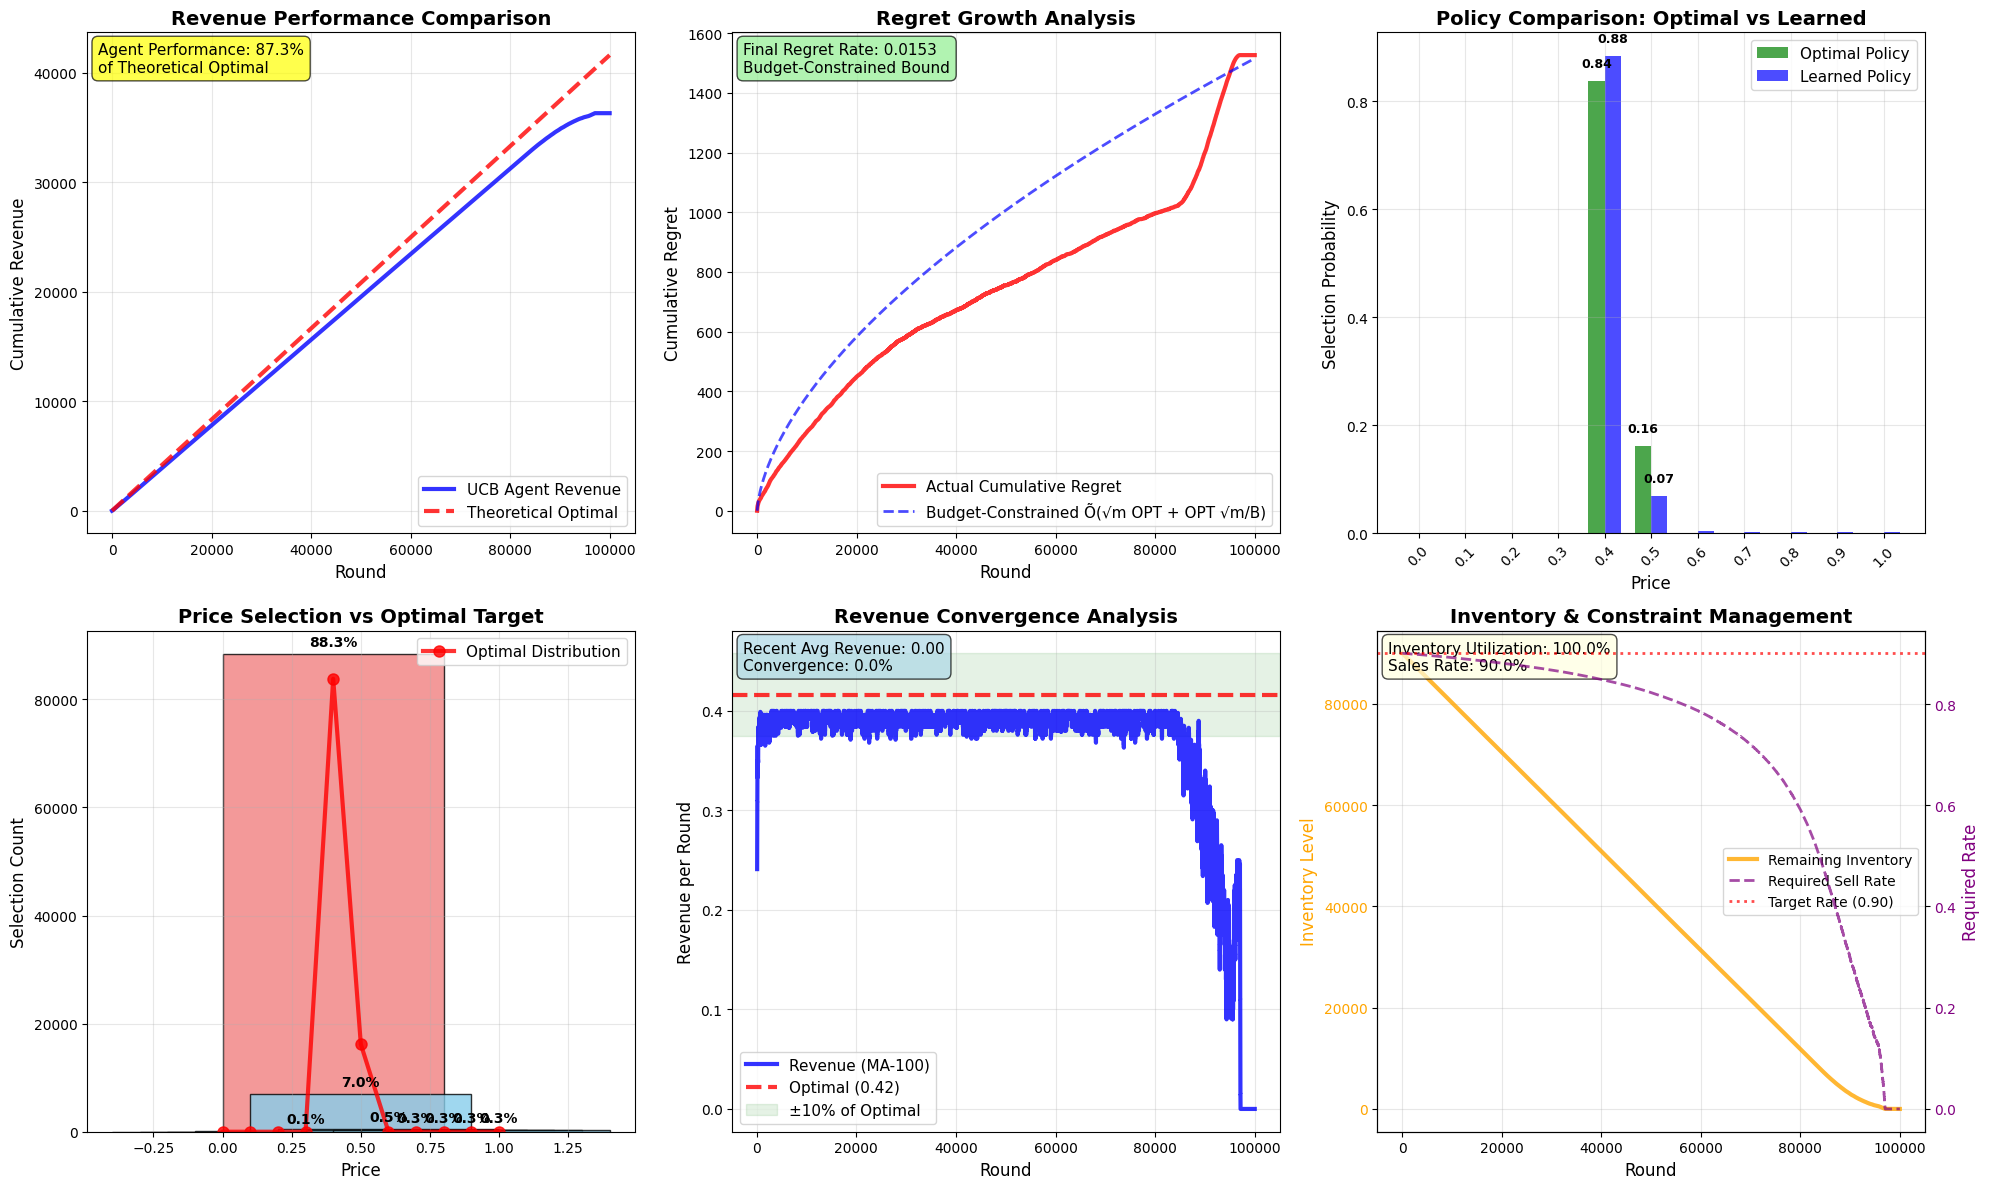

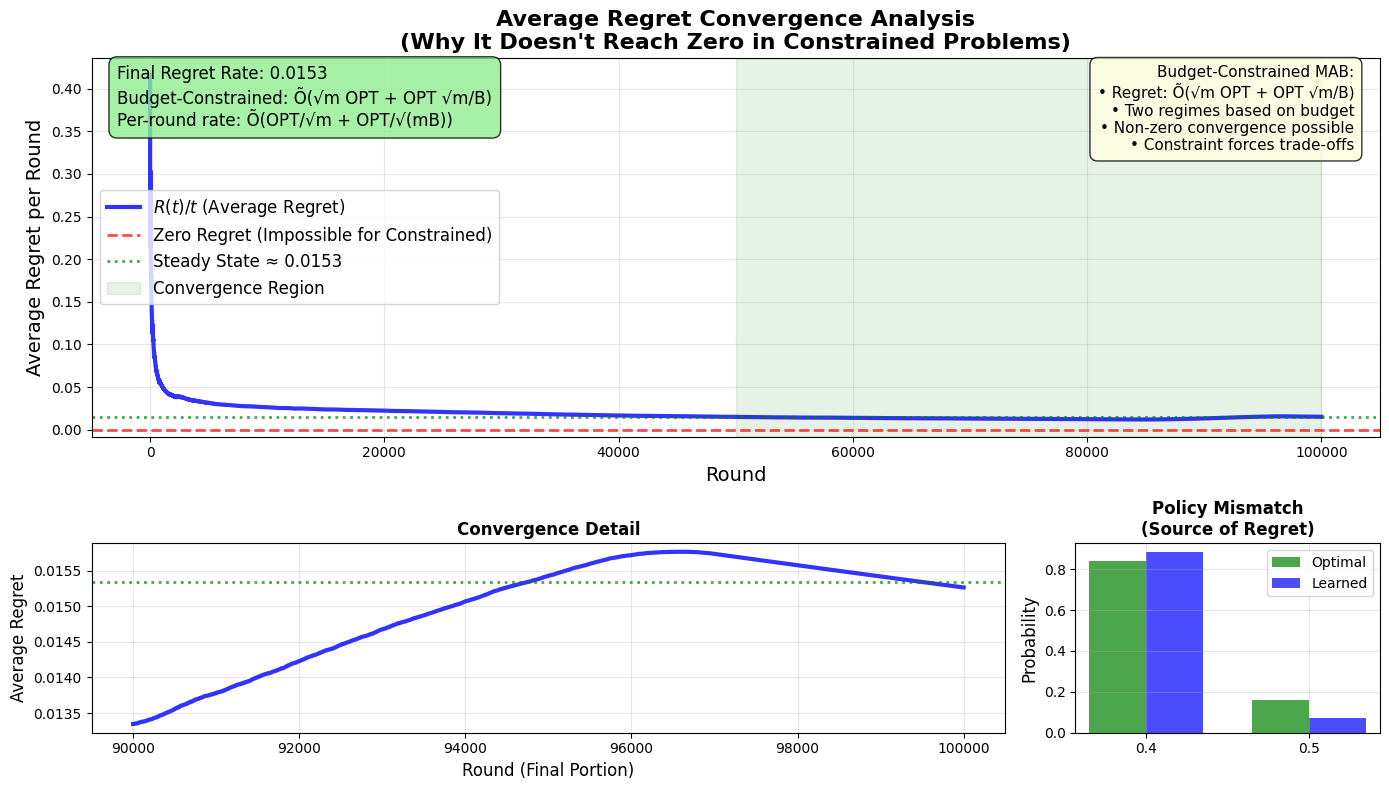


=== Regret Growth Analysis ===
Estimated regret exponent (log-log slope): 0.680
R-squared: 0.913
Budget-constrained regret bound: Õ(√m OPT + OPT √m/B)
Component 1 (√m OPT): 132
Component 2 (OPT √m/B): 0
Expected log-log slope: 0.500
Regime: High Budget (B=90000 ≥ √T=316): √m OPT dominates
Dominant bound value: 132
✓ Regret growth is sublinear (slope < 1.0)

=== Summary Statistics ===
Convergence rate: 96.3%
Average revenue per round: 0.36
Revenue std deviation: 0.12
Total sales made: 90000
Sales rate: 90.0%
Remaining inventory: 0.0
Total regret (improved calculation): 1526.34
Average regret per round: 0.0153
Inventory utilization: 100.0%


In [12]:

plot_res=plot_results(T, revenues, cumulative_revenue, price_counts, agent_params, sales, agent, valuation_dist, env_config)
